# Imports

In [219]:
from utils import data as udata
from utils import geo as ugeo
from utils import utils as uutils
from utils import viz as uviz
from utils import networks as unetworks

import calendar as cal
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pylab as plt
import networkx as nx
import community
from infomap import infomap
import plotly.plotly as py
import plotly.graph_objs as gos

# Data

## Pull

In [5]:
# Get a list of all periods like ['january_2013', 'february_2013', ...]
all_periods = [
    "%s_%s" % (month.lower(), year)
    for year in ["2013", "2014", "2015", "2016"]
    for month in [cal.month_name[m] for m in range(1, 13)]
]

# Put all location events into `df_locations`
df_locations = udata.get_datatype_period("location", all_periods, sort=True)

# Extract users from dataset
users = np.sort(df_locations['user'].unique())

## Label

In [27]:
# Choose a user
u = 317

# Extract user coordinates
df_u = df_locations.loc[df_locations['user'] == u]
coords_u = np.array(df_u.loc[:, ['lat', 'lon', 'timestamp']])

# Get stop location labels for each GPS point
labels = ugeo.get_stop_location_labels(coords_u[:, :2])

# Stack labels onto coordinate array
coords_u = np.hstack([coords_u, labels.reshape(-1, 1)])

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ulfaslak@gmail.com/projects/scales_of_human_mobility/utils/geo.py:164: RuntimeWarning: invalid value encountered in true_divide
  def _norm_dist(p):
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


In [222]:
np.savetxt("data/coords_317.txt", coords_u, delimiter=",")
#coords_u = np.load("data/coords_317.npy")

In [3]:
Counter(coords_u[:-1, 2] - coords_u[1:, 2])

Counter({-883800.0: 1,
         -710100.0: 1,
         -443700.0: 1,
         -293400.0: 1,
         -60300.0: 1,
         -56700.0: 1,
         -47700.0: 1,
         -44100.0: 1,
         -32400.0: 1,
         -31500.0: 1,
         -28800.0: 1,
         -27000.0: 3,
         -23400.0: 1,
         -21600.0: 1,
         -16200.0: 1,
         -15300.0: 3,
         -14400.0: 1,
         -13500.0: 2,
         -12600.0: 1,
         -11700.0: 2,
         -10800.0: 6,
         -9900.0: 3,
         -9000.0: 4,
         -8100.0: 7,
         -7200.0: 6,
         -6300.0: 5,
         -5400.0: 7,
         -4500.0: 119,
         -3600.0: 330,
         -2700.0: 31,
         -1800.0: 47,
         -900.0: 70734,
         0.0: 880})

# Analysis

## Lauras paper

Just for fun, can I quickly get some idea of how large a persons portfolio of locations is over a one-month window?

In [31]:
x, y, z, c = [], [], [], 0
for i, l in enumerate(labels):
    if l not in labels[:i]:
        c += 1
    x.append(i/96)
    y.append(c)
    z.append(len(set(labels[max(0, i-96*7*4):i])))

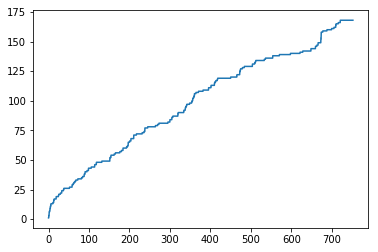

In [34]:
plt.plot(x, y)
plt.show()

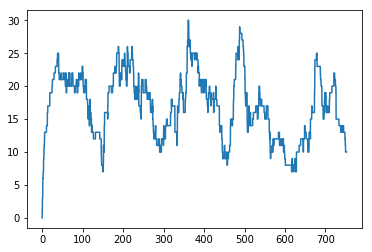

In [33]:
plt.plot(x, z)
plt.show()

## Graph

In [31]:
coords_u_stat = coords_u[coords_u[:, 3] != -1]

counter = Counter([e for e in zip(coords_u_stat[:-1, 3], coords_u_stat[1:, 3]) if e[0] != e[1]])
G = unetworks.multigraph_to_weighted_graph(nx.MultiDiGraph([e for e in zip(coords_u_stat[:-1, 3], coords_u_stat[1:, 3]) if e[0] != e[1]]), digraph=True)

In [17]:
infomapWrapper = infomap.Infomap("--two-level")
for e, w in counter.items():
    infomapWrapper.addLink(int(e[0]), int(e[1]), w)
    
infomapWrapper.run()
tree = infomapWrapper.tree

partition = dict((node.physIndex, node.moduleIndex()) for node in tree.leafIter())

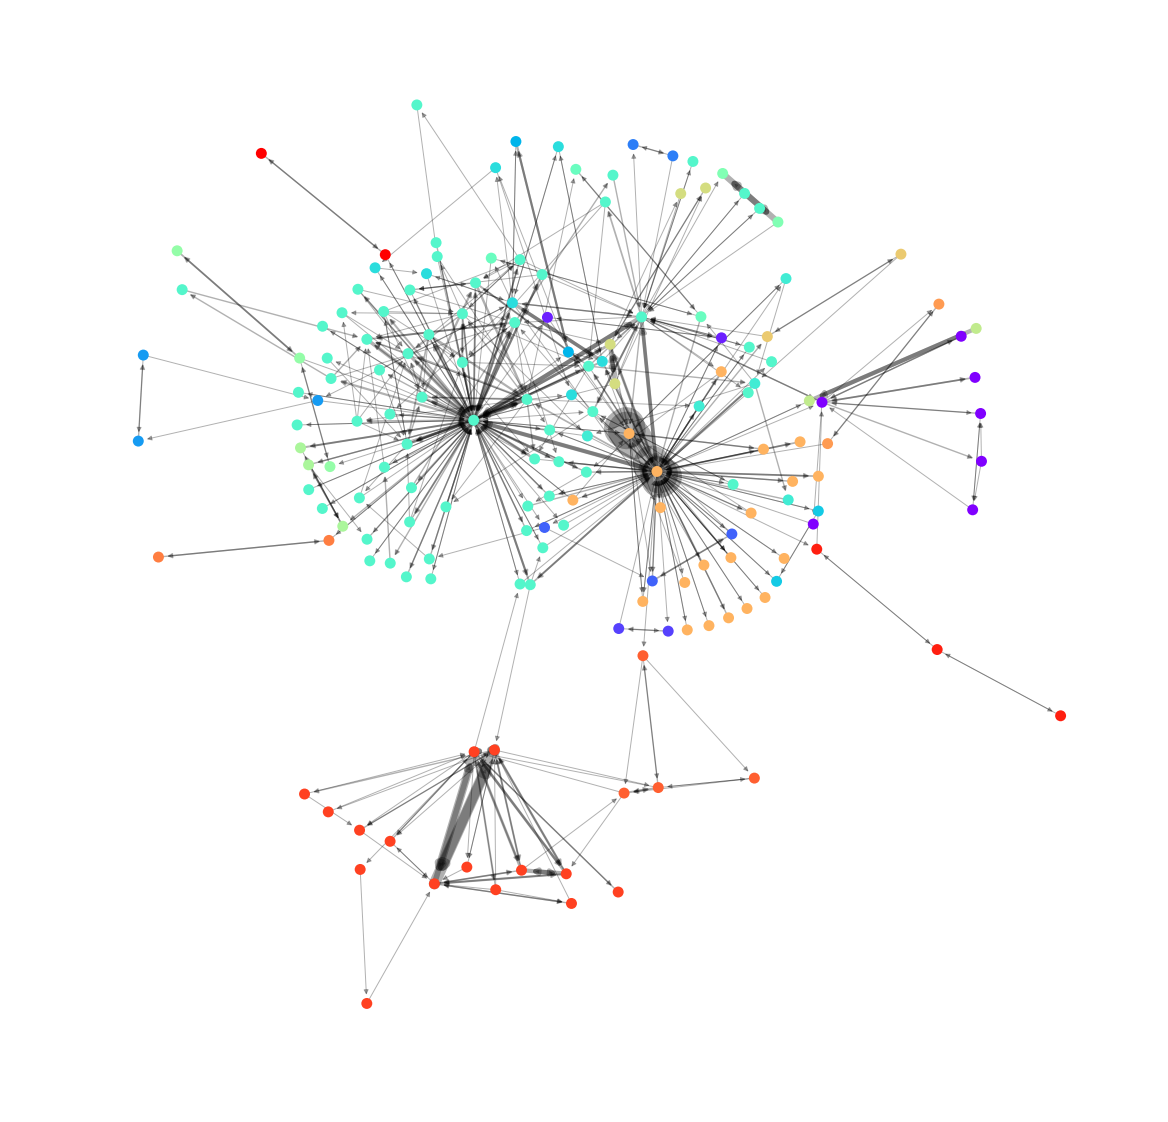

In [53]:
plt.figure(figsize=(20, 20))
uviz.draw(G, partition=partition)
plt.show()

## Map

In [220]:
import folium

In [221]:
cmap = uviz.cmap_in_categories(set(partition.values()), return_hex=True)
mapbox_access_token = 'pk.eyJ1IjoidWxmYXNsYWsiLCJhIjoiY2pmcng3ZDNmM2k3aTJxcWYzZjBuN3p3cSJ9.1qq_YEUyul8RB8VzEoOk_w'

m = folium.Map(
    location=(56, 12), zoom_start=6,
    tiles="https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=%s" % mapbox_access_token,
    attr="lol"
)

html = df.to_html(classes='table table-striped table-hover table-condensed table-responsive')

for d in stop_locations:
    folium.CircleMarker(
        d[:2],
        color="#00000000",
        fill_color=cmap(partition[d[2]]),
        fill_opacity=1,
        popup=str(partition[d[2]]),
        fill=True
    ).add_to(m)

m